In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import pickle
import scipy.io
from timeit import default_timer as timer
import datetime
import sys
import os
from os.path import dirname, abspath
sys.path.append(dirname(dirname(dirname(abspath('__file__')))))

import cProfile
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
import bayesian_changepoint_detection2.online_changepoint_detection as oncd
from matplotlib.colors import LogNorm
from scipy.stats import norm
from functools import partial

from utils.read_answers import ReadAnswers
from utils.check_performance import checkPerformance
from utils.line_suppression import seg_line_sup

%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Use scipy logsumexp().


### Real data

In [3]:
## Input the filenames and parameters:
filename =  'AmsData_lage_corrected_int_all.pkl' # 'AmsData_hoge_measurements_all.pkl'
original_indices = 'orig_x.npy'
full_indices = 'full_time_index.npy'
filename_answers = 'lage_segm_lines_31052020.txt'
interpolation_method = 'linear'

## Create variables with directories to external files:
directory = os.path.join(dirname(dirname(os.getcwd())), 'data_files/')
file_data = os.path.join(directory, filename)
file_full_indices = os.path.join(directory, full_indices)
file_orig_indices = os.path.join(directory, original_indices)
file_answers = os.path.join(directory, filename_answers)

## Import the measurements:
data_imported = pd.read_pickle(file_data)
mydata = data_imported[interpolation_method].copy()

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
full_x = np.load(file_full_indices) 
indices = [int(i*365.25/11) for i in orig_x]

## Load the answers (ground truth):
answers = ReadAnswers(file_answers)
ans = pd.DataFrame(answers['segm_lines'], index = answers.index)
ans.columns = ['segm']
## For full time T-S:
for i in range(100):
    ans.segm.iloc[i] = [indices[y] for y in ans.segm.iloc[i]]

## Mask to choose only the examples with provided GT (ground truth):
mask_segm = ans.segm.apply(lambda x: x != [])
ans[mask_segm]
ans_segm_only = ans.iloc[np.where(mask_segm)[0]]
mydata_segm_only = mydata.iloc[ans.index[np.where(mask_segm)[0]]].copy()

## Reverse indices using the last existing index
indices_reverse = []
for i in range(297):
    if i in indices:
        indices_reverse.append(i)
    else:
        indices_reverse.append(indices_reverse[i-1])

### Simulated data

In [4]:
## Input the filenames and parameters:
filename = 'segmented_ts_sim_with_UE_02.pkl'
original_indices = 'orig_x.npy'
full_indices = 'full_time_index.npy'
interpolation_method = 'original'

## Create variables with directories to external files:
directory = os.path.join(dirname(dirname(os.getcwd())), 'data_files/')
file_data = os.path.join(directory, filename)
file_full_indices = os.path.join(directory, full_indices)
file_orig_indices = os.path.join(directory, original_indices)

data_imp = pd.read_pickle(file_data)
mydata = data_imp['time-series with UE']
ans = pd.DataFrame(data_imp['segm_lines'], index = data_imp.index)
ans.columns = ['segm']

orig_x = np.load(file_orig_indices)
indices = [int(i*365.25/11) for i in orig_x]

# ## For full time T-S:
# for i in range(100):
#     ans.segm.iloc[i] = [indices[y] for y in ans.segm.iloc[i]]

## Mask to choose only the examples with provided GT (ground truth):
mask_segm = ans.segm.apply(lambda x: x != [])
ans[mask_segm]
ans_segm_only = ans.iloc[np.where(mask_segm)[0]]
mydata_segm_only = mydata.iloc[ans.index[np.where(mask_segm)[0]]].copy()

## Reverse indices using the last existing index
indices_reverse = []
for i in range(297):
    if i in indices:
        indices_reverse.append(i)
    else:
        indices_reverse.append(indices_reverse[i-1])

### Algorithm

In [5]:
def bayesian_changepoint(data, prints=False):

    Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior,  l=(len(data))), 
                                                    offcd.gaussian_obs_log_likelihood, truncate=-40)

    
    chp = list(np.where(np.exp(Pcp).sum(0) > 0.3)[0])
#     chp = [p - 1 for p in chp]
    if prints:
        fig = plt.figure(figsize=[18, 16])
        ax1 = plt.subplot(211)
        ax1.plot(data[:])
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid()
        ax1.set_axisbelow(True)
        ax2 = plt.subplot(212, sharex=ax1)
        ax2.plot(np.exp(Pcp).sum(0))
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid()
        ax2.set_axisbelow(True)
        fig.tight_layout()
        plt.show()

        print(chp)
        print(np.exp(Pcp).sum(0)[chp])
        plt.figure(figsize=(30,16))
        plt.plot(full_x, data, '-o')
        plt.plot(full_x, data - 18.1, '-o', alpha=0.3)
        for i in chp:
            plt.axvline(full_x[i],0,1, linestyle='--', color='k', zorder=5)
#         for j in ans_segm_only.iloc[ts_num]['segm']:
#             plt.axvline(indices[j],0,1, linestyle='-', color='red')
    #     print(ans_segm_only.iloc[ts_num]['segm'])
    #     print(ans_segm_only.index[ts_num])
    
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid()
        plt.show()

    return chp, np.exp(Pcp).sum(0)[chp]


In [6]:
def plot_segments(data, gt, ans, labels, one_plot=False, with_copy=True):
        
        cmap = plt.get_cmap("tab10")
        markers = ['v', '^', 's', 'P', 'X', 'D']
        
        if with_copy:
            size = 16
        else:
            size = 8
            
        line = []
        used_labels = []
        
        if one_plot:
            plt.figure(figsize=(30,size))
            plt.plot(indices, data, '-o')
            if with_copy:
                plt.plot(indices, data - 18.1, '-o', alpha=0.3)
            for i in range(len(ans)):
                for j in ans[i]:
                    tmp_line = plt.axvline(indices[j],0.02,0.98, linestyle='--', marker=markers[i], markersize=10,
                                           linewidth=2, color=cmap(i), zorder=5)
                if len(ans[i]):
                    line.append(tmp_line)
                    used_labels.append(labels[i])
            if len(gt):
                for k in gt:
                    gt_line = plt.axvline(indices[k],0,1, linestyle='-', linewidth=2, color='black', zorder =4)
                line.append(gt_line)
                used_labels.append('GT')
            plt.legend(line, used_labels)
            plt.grid()
            plt.title('Time-series segmentation', fontsize=16)
            plt.xlabel('Index', fontsize=16)
            plt.ylabel('Deformation [mm]', fontsize=16)
            plt.show()

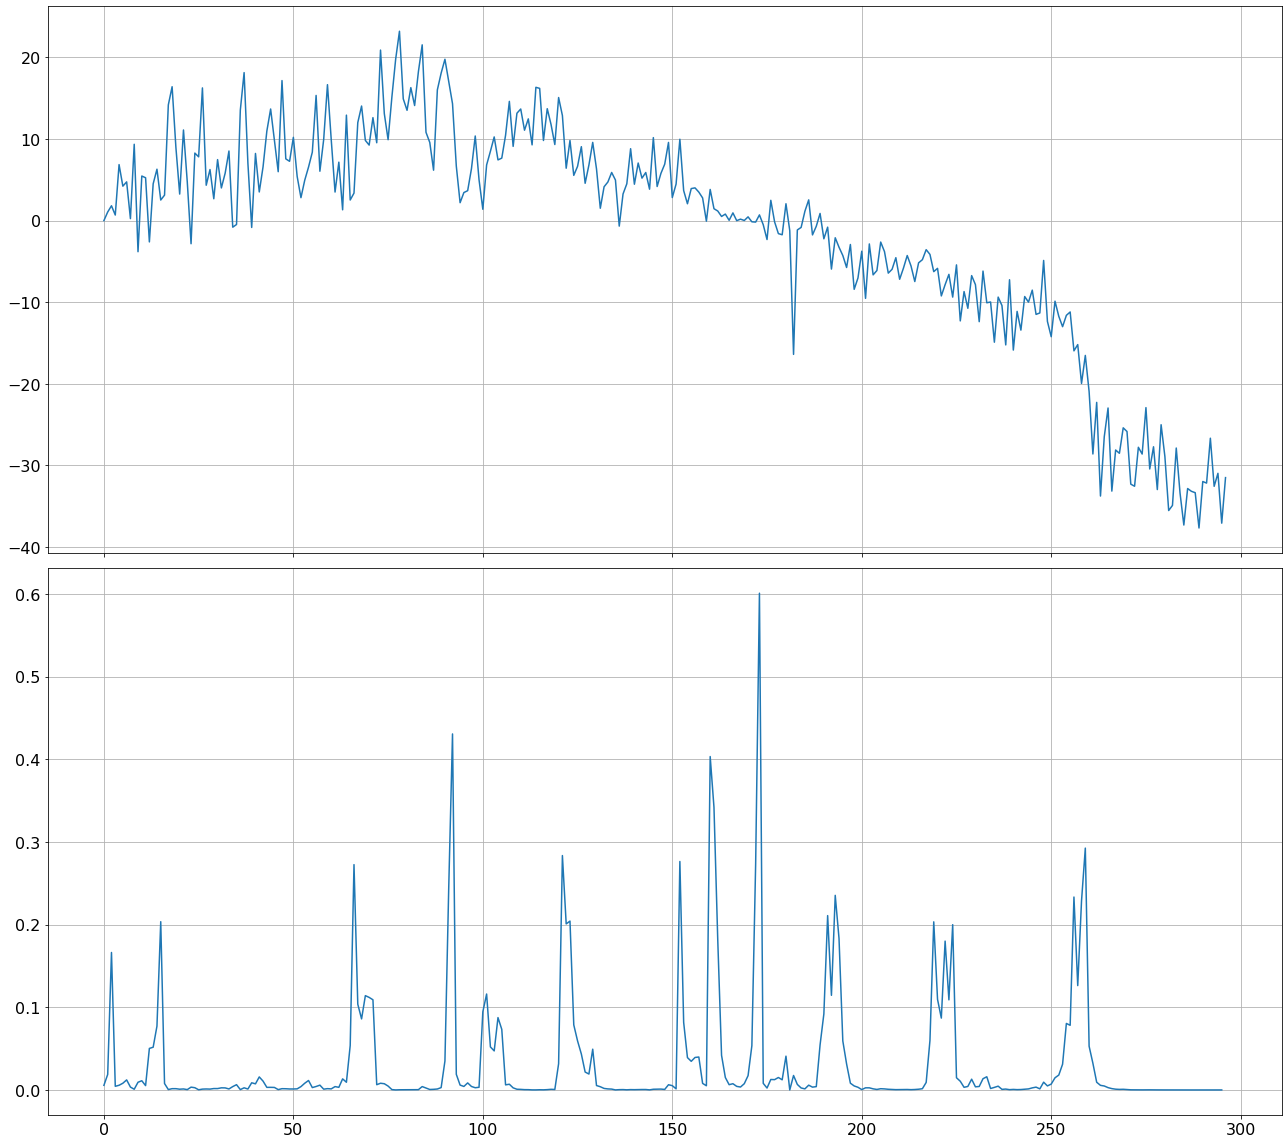

[92, 160, 161, 173]
[0.43068077 0.40332585 0.34195487 0.60093724]


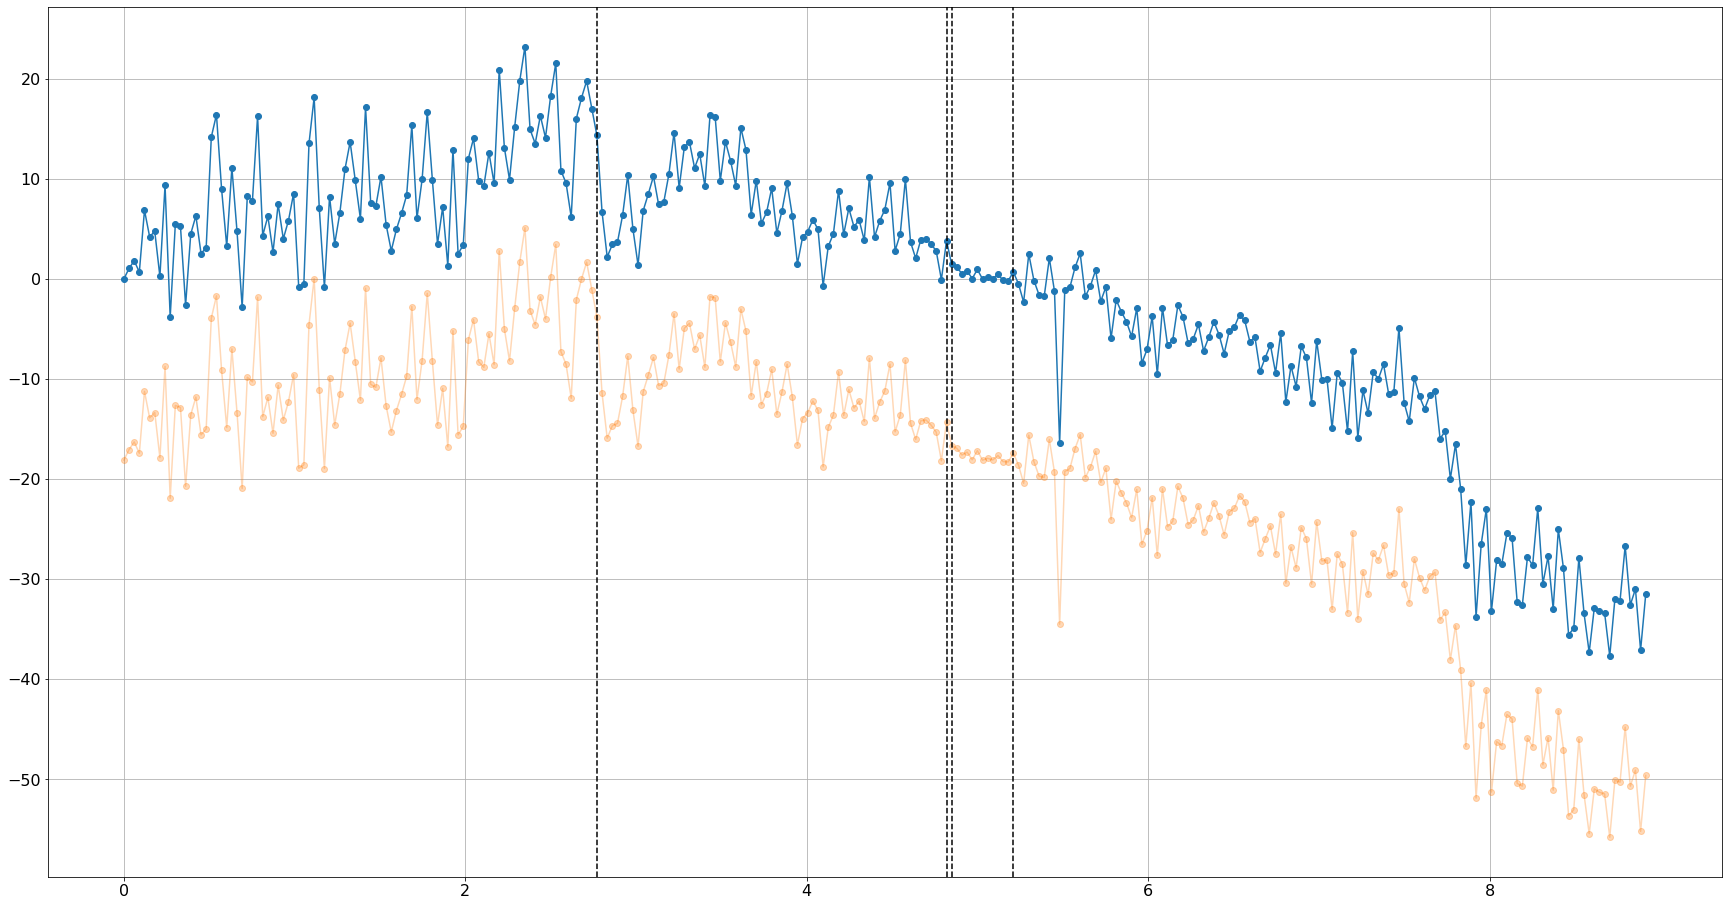

i:  10 ts_num:  10
Ground truth:  [93, 123, 261]
BOCD:  [92, 160, 161, 173]


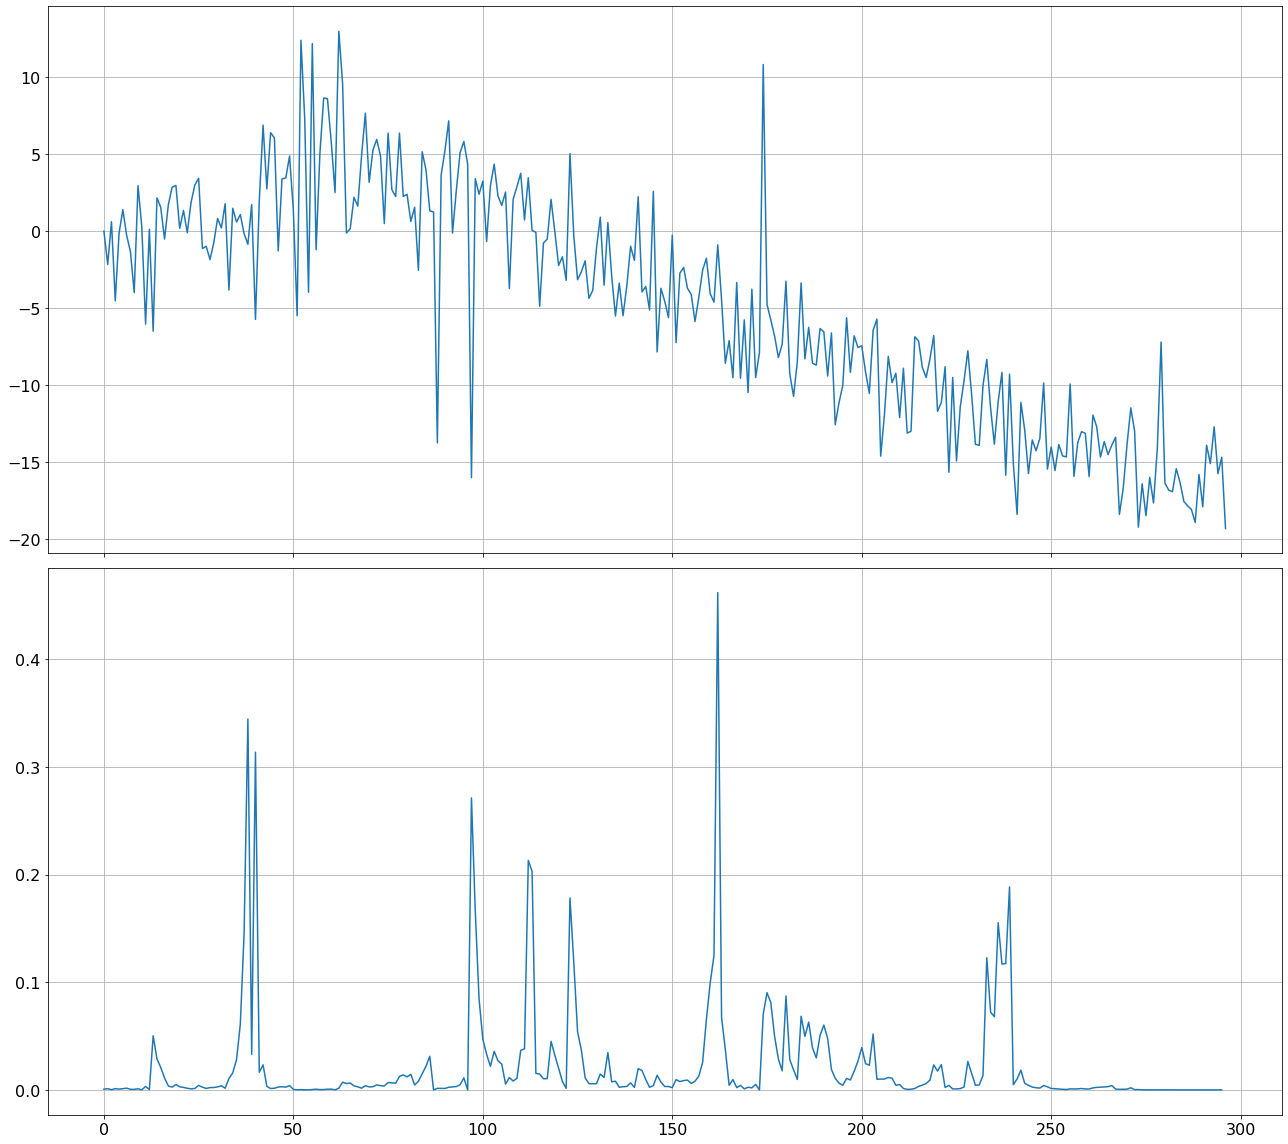

[38, 40, 162]
[0.34430818 0.31355861 0.46170097]


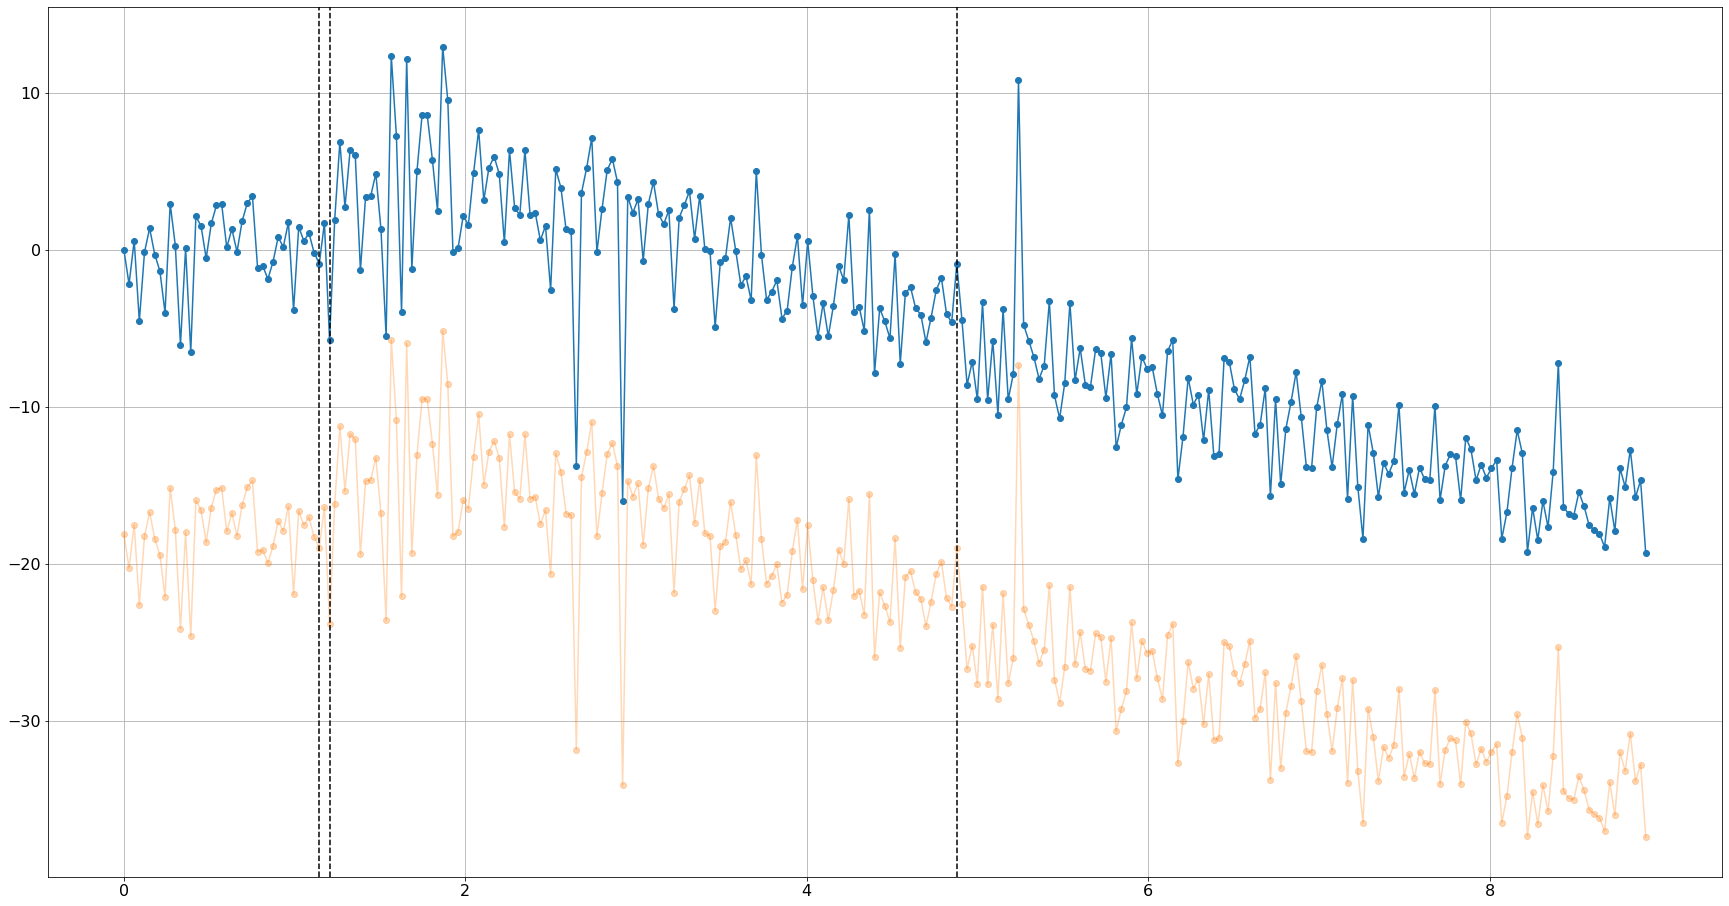

i:  11 ts_num:  11
Ground truth:  [44, 69, 247]
BOCD:  [38, 40, 162]


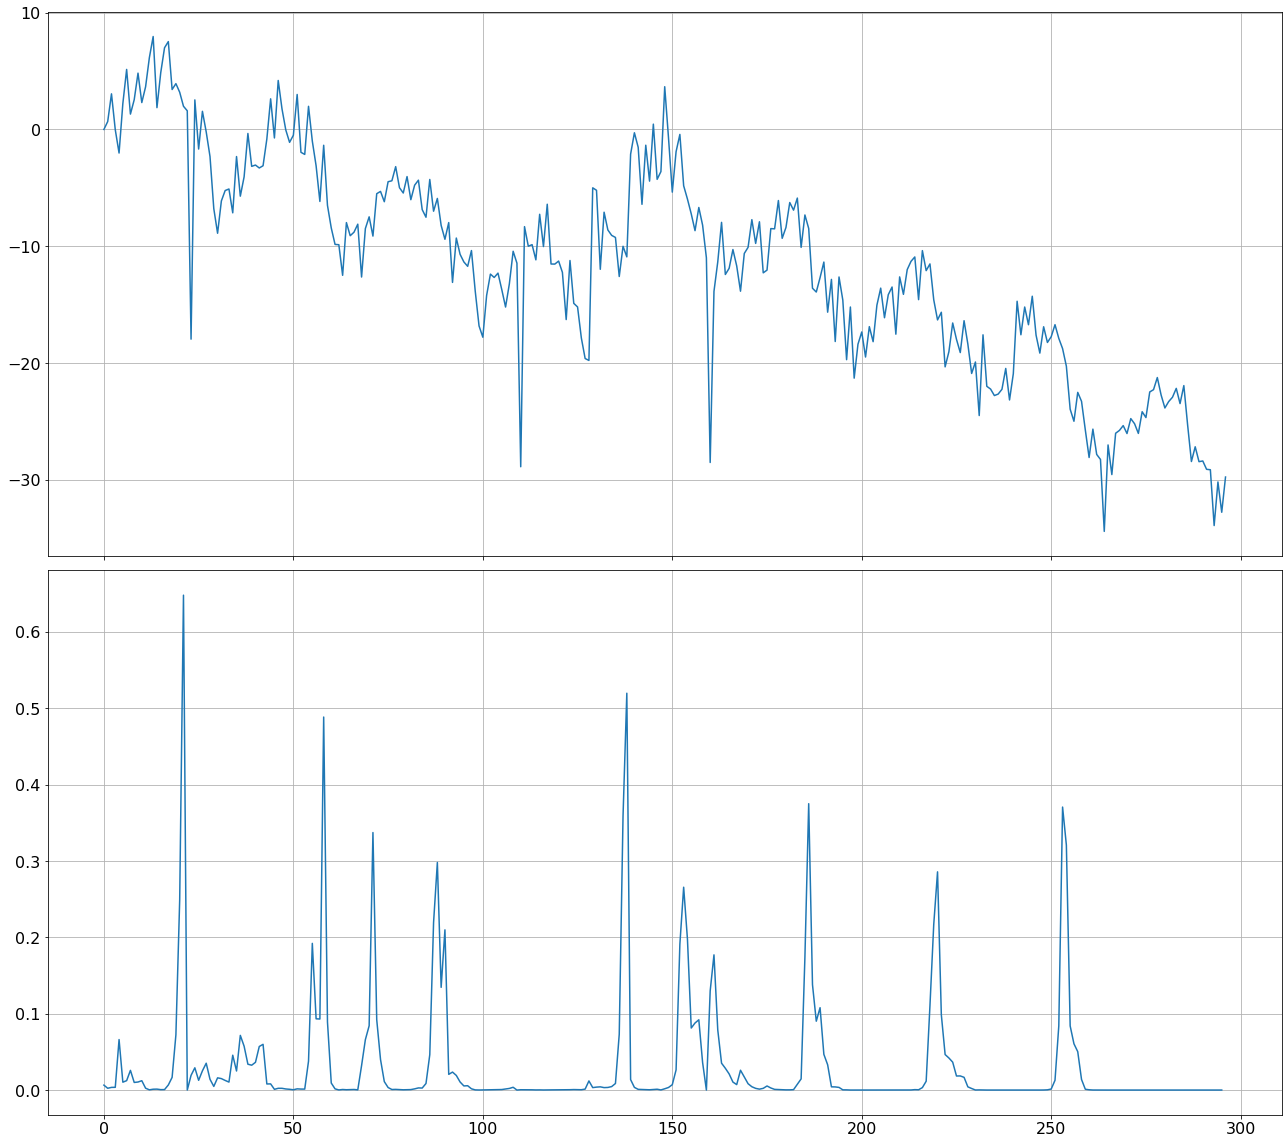

[21, 58, 71, 137, 138, 186, 253, 254]
[0.6481082  0.4885172  0.33724175 0.35868593 0.51971143 0.37503395
 0.37061613 0.32084562]


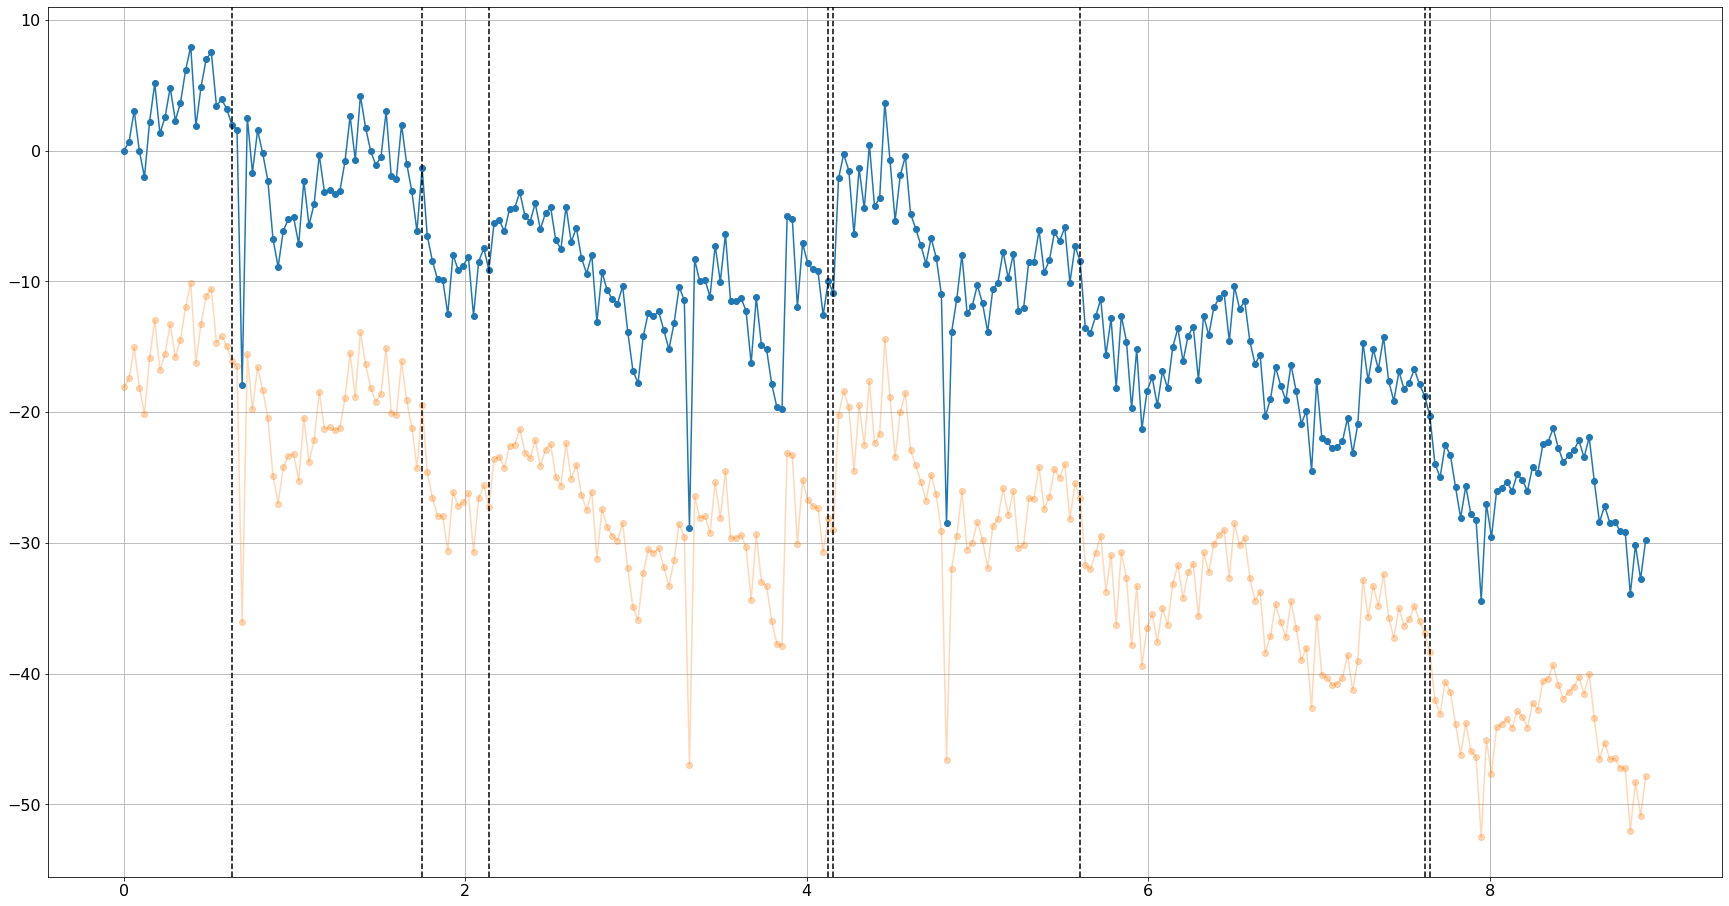

i:  12 ts_num:  12
Ground truth:  [129]
BOCD:  [21, 58, 71, 137, 138, 186, 253, 254]


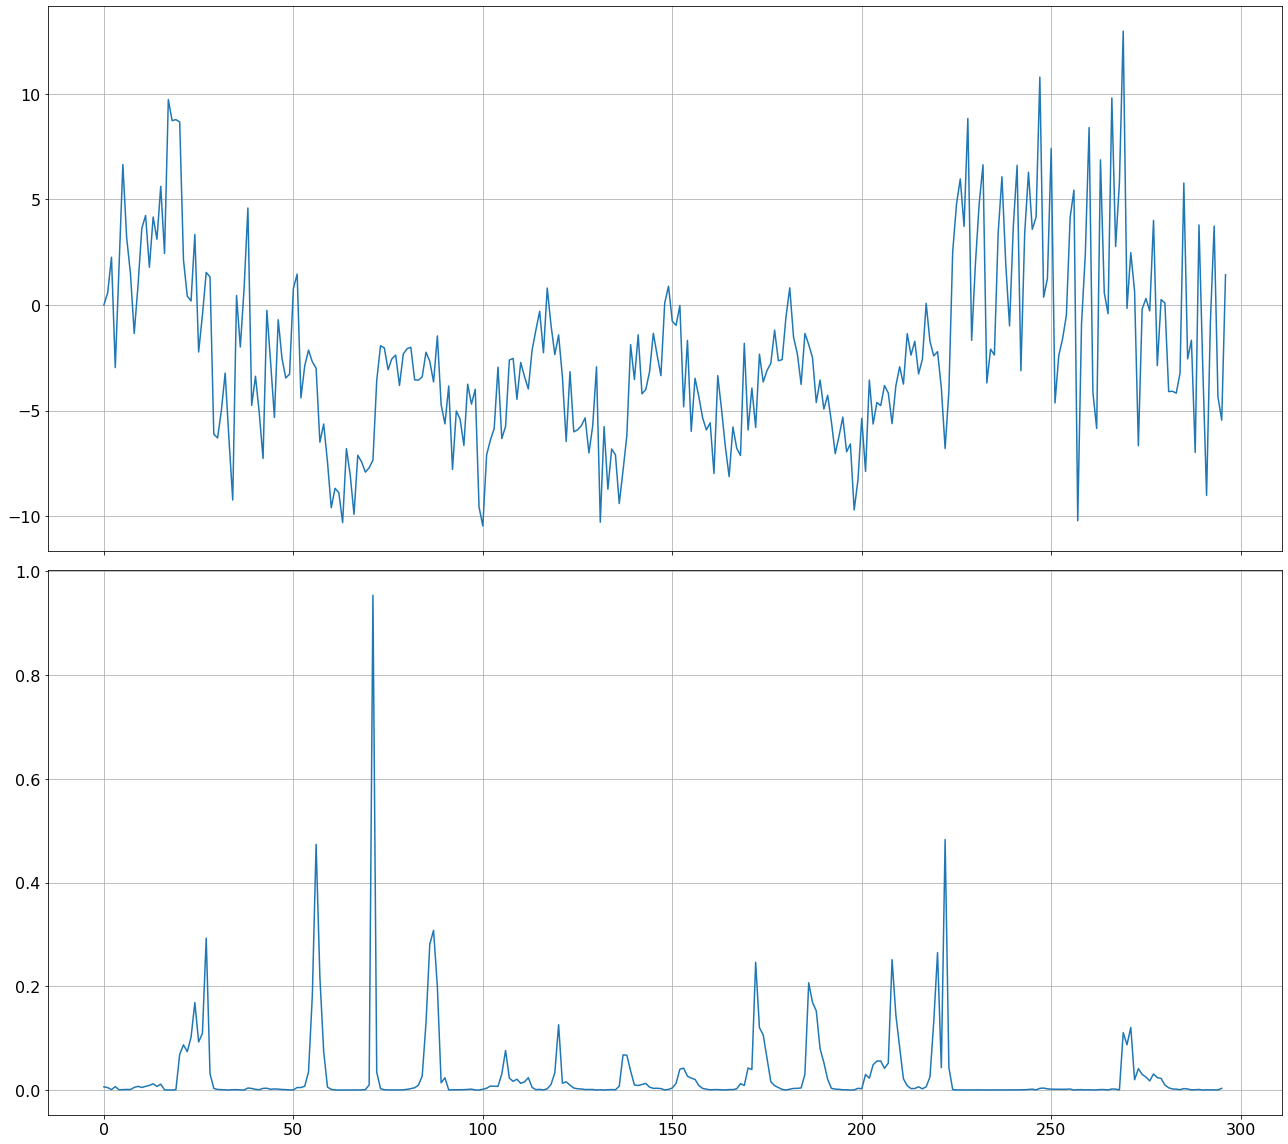

[56, 71, 87, 222]
[0.47342384 0.95365496 0.30787386 0.48279455]


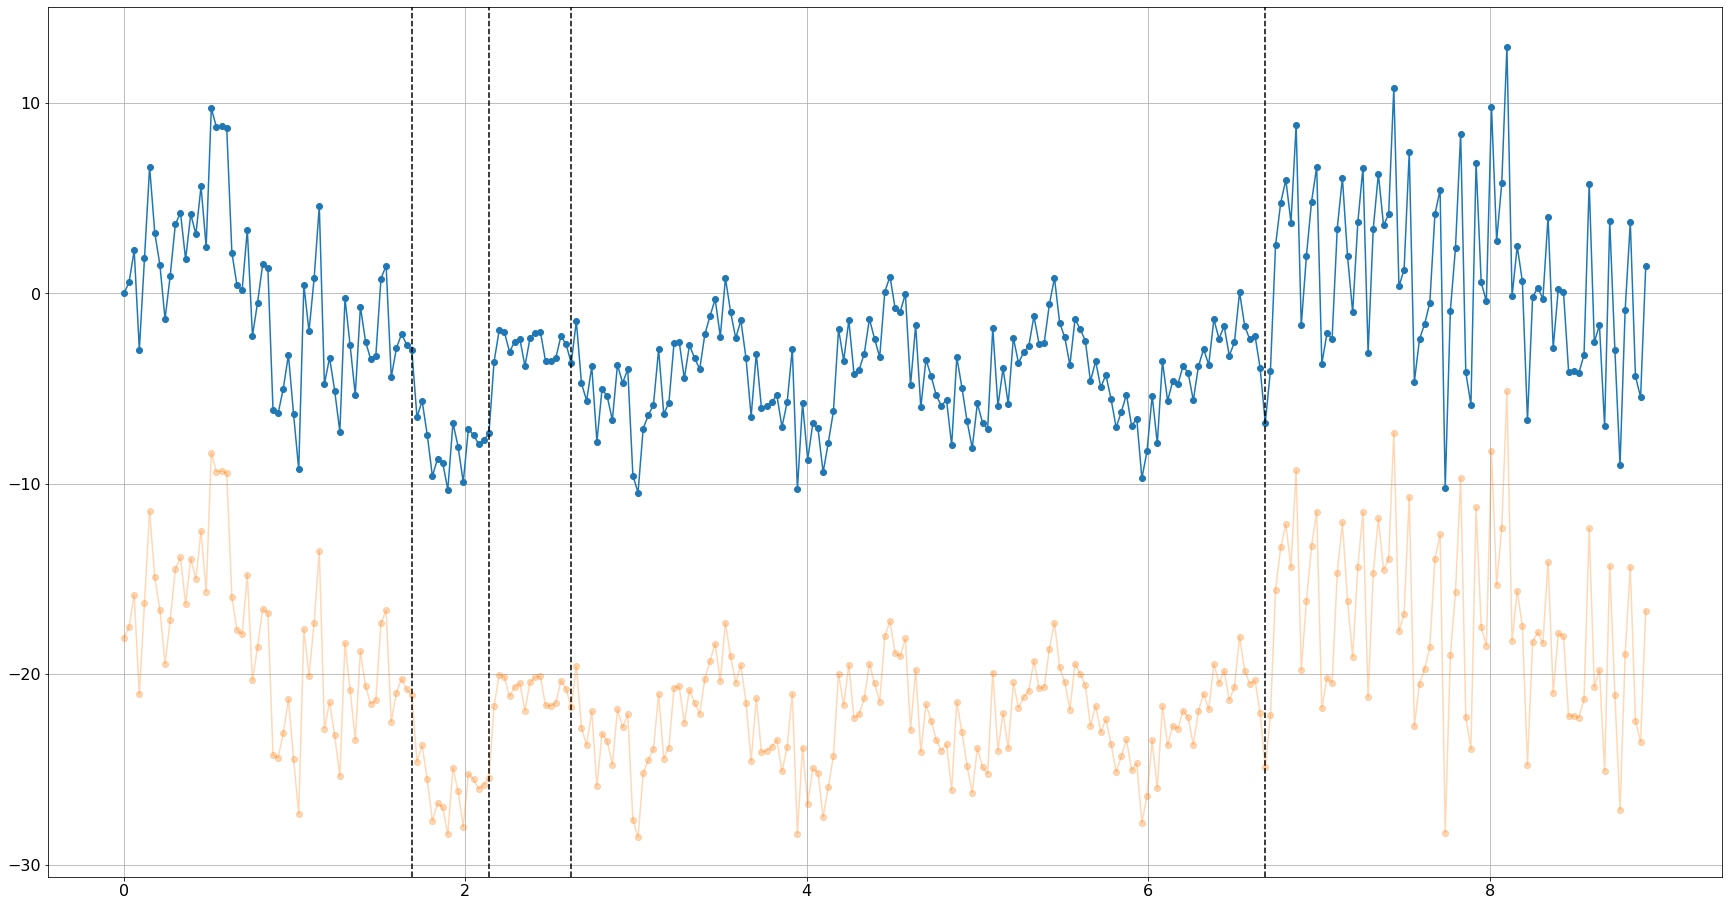

i:  13 ts_num:  13
Ground truth:  [43, 224]
BOCD:  [56, 71, 87, 222]


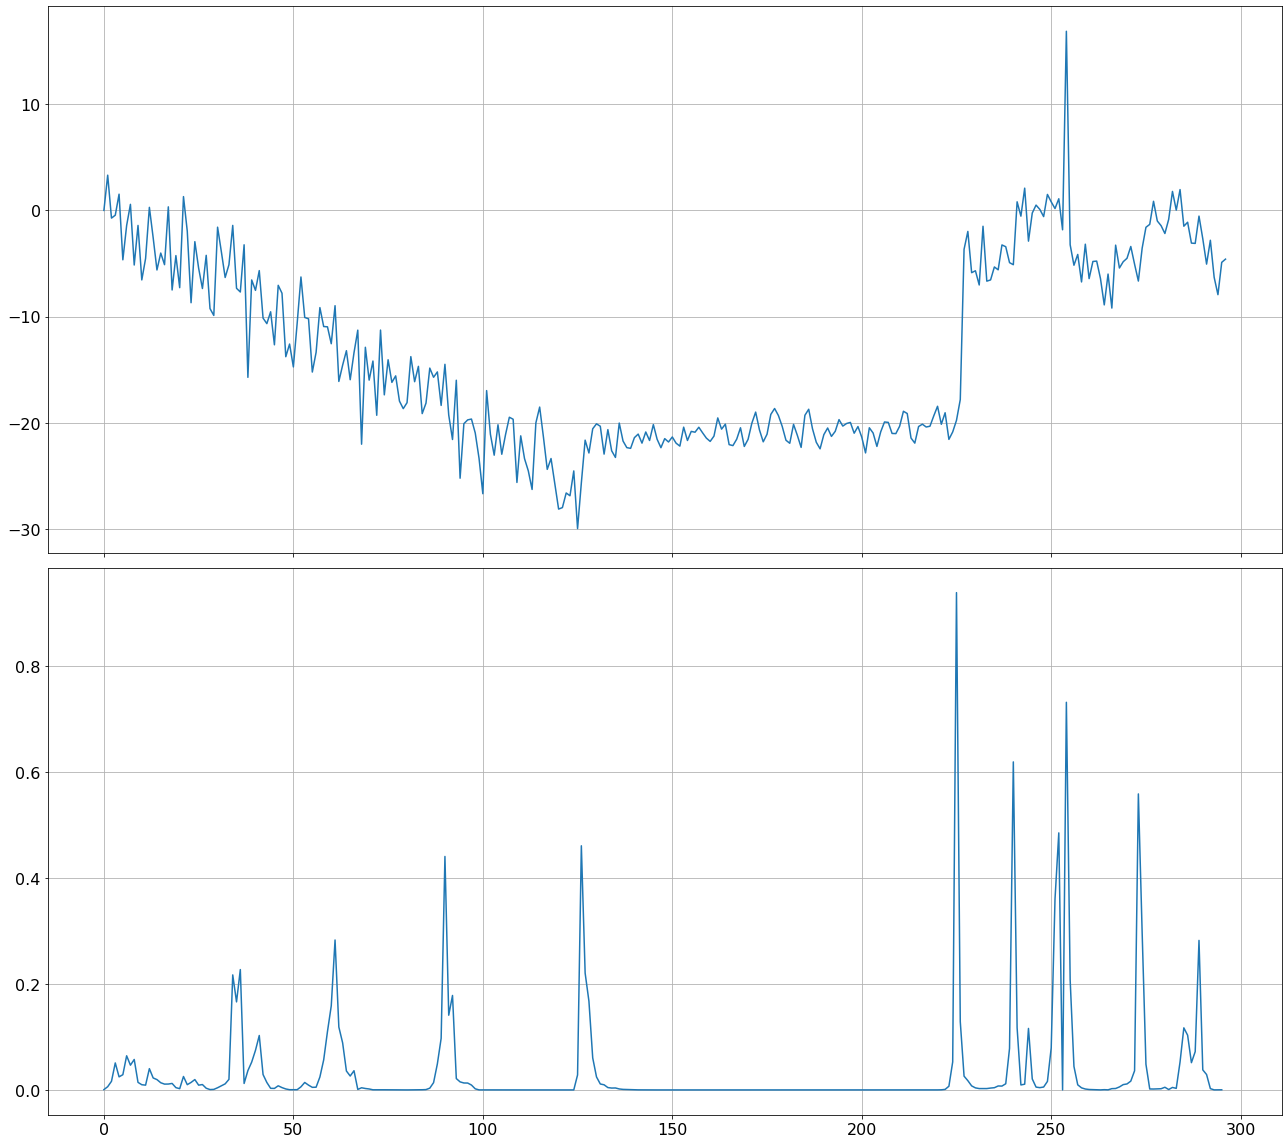

[90, 126, 225, 240, 251, 252, 254, 273]
[0.44074983 0.46090611 0.93885957 0.61928252 0.36009327 0.48526764
 0.7318181  0.55882743]


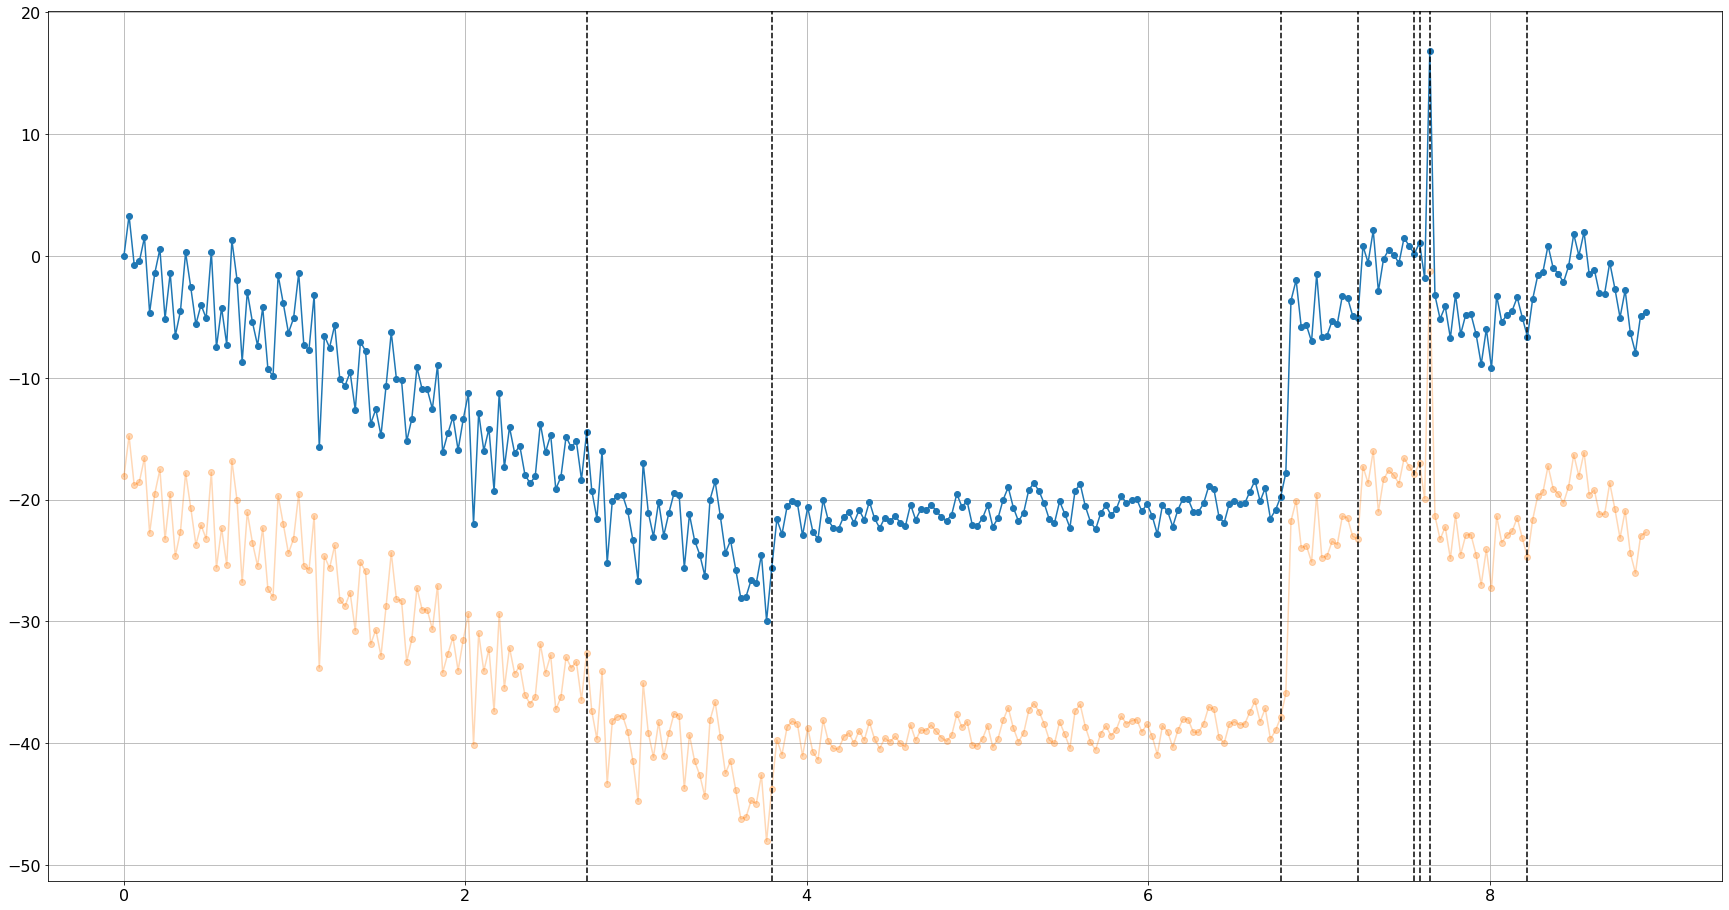

i:  14 ts_num:  14
Ground truth:  [128, 227]
BOCD:  [90, 126, 225, 240, 251, 252, 254, 273]


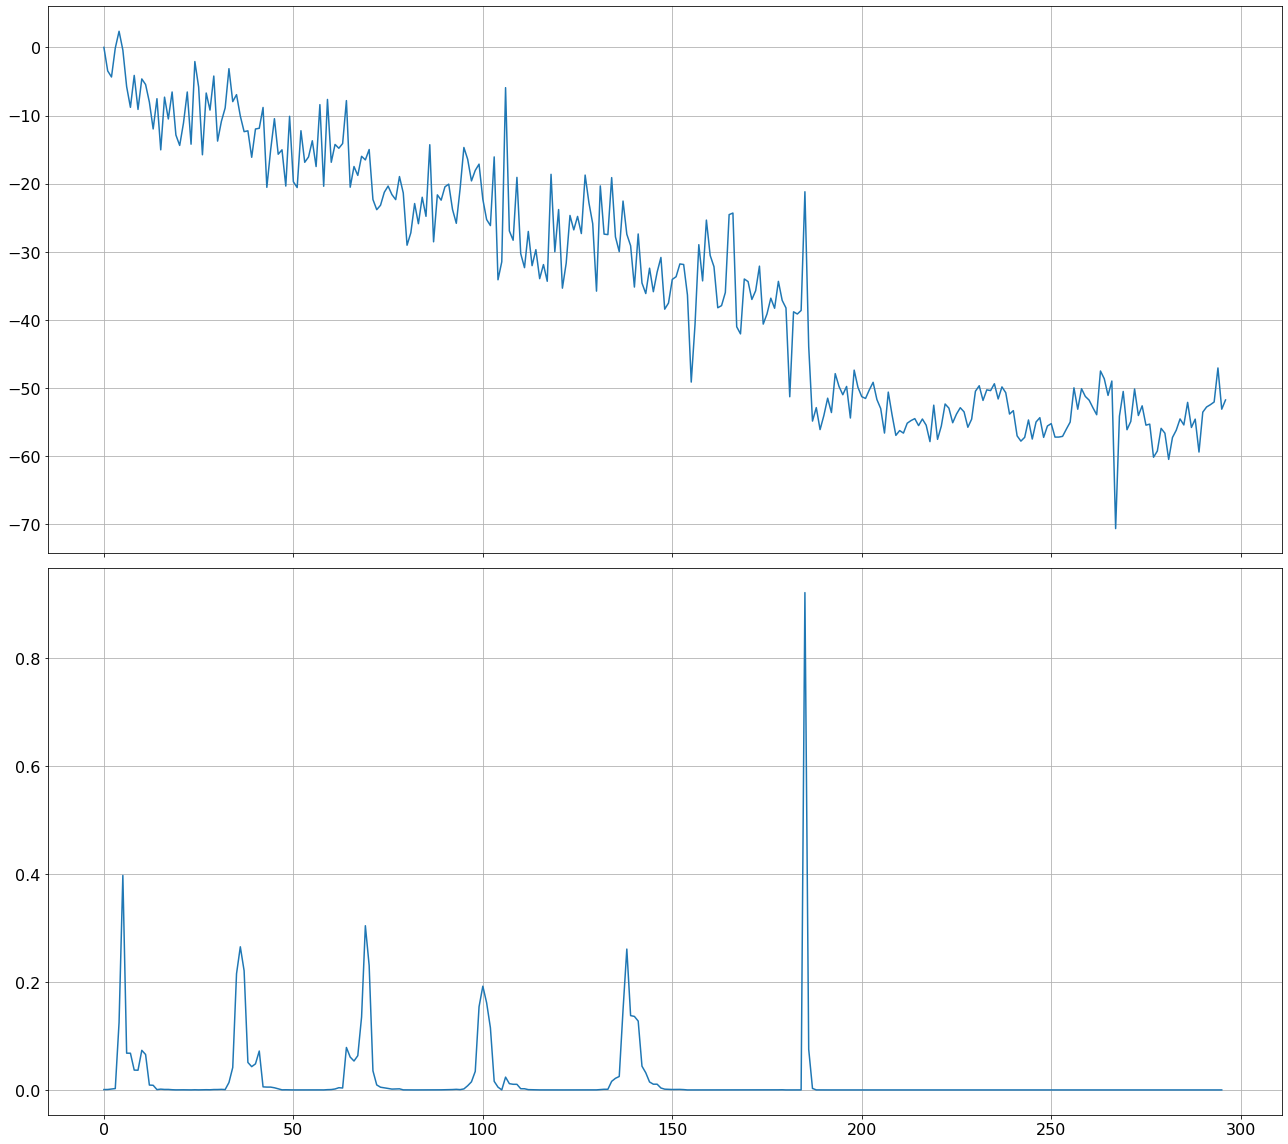

[5, 69, 185]
[0.39764743 0.30439892 0.92189078]


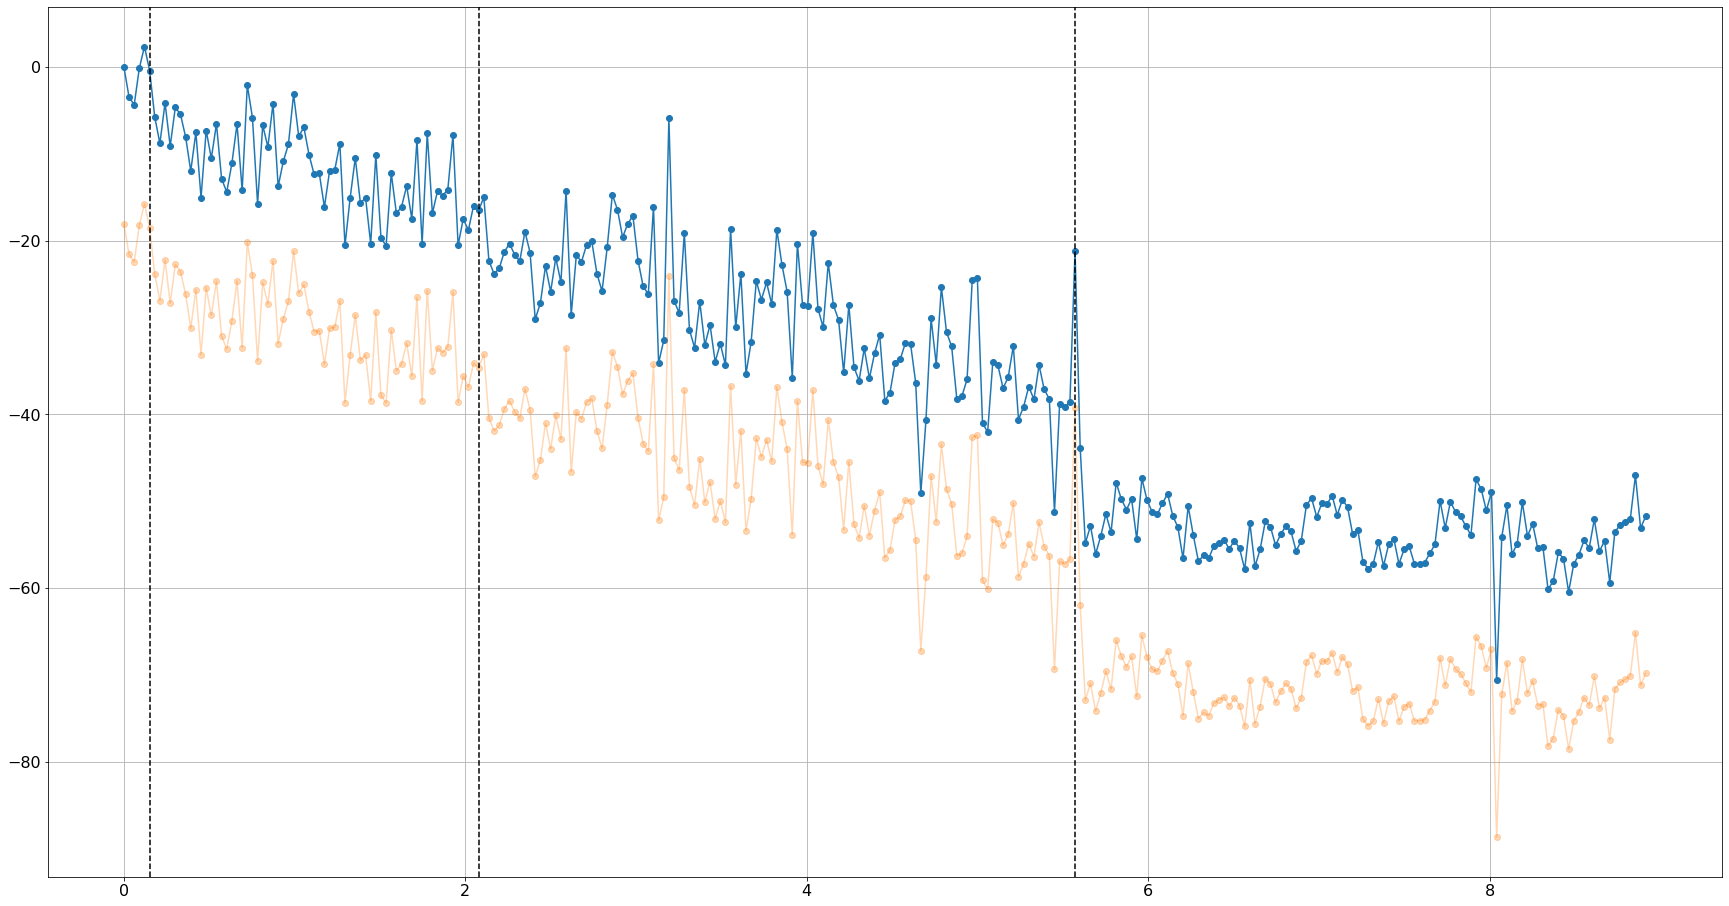

i:  15 ts_num:  15
Ground truth:  [35, 53, 187]
BOCD:  [5, 69, 185]


KeyboardInterrupt: 

In [8]:
results = {}
results['BOCD'] = []
results['BOCD_SUP'] = []
start = timer()
for i in range(10,20):
    ts_num = i
    data = mydata.iloc[ans.index[ts_num]]
    chp, vals = bayesian_changepoint(data, prints=True)
    if chp:
        chp_sup = seg_line_sup(chp, vals)
    else:
        chp_sup = []
    print('i: ', i, 'ts_num: ', ans.index[ts_num])
    print('Ground truth: ', ans.segm.iloc[ts_num])
    print('BOCD: ', chp)
    results['BOCD'].append(chp)
    results['BOCD_SUP'].append(chp_sup)
end = timer()
print('Time elapsed:', end - start)

In [9]:
results['BOCD2'] = []
for line in results['BOCD']:
    tmp = [indices_reverse[x] for x in line]
    results['BOCD2'].append(tmp)
    
results['BOCD_SUP2'] = []
for line in results['BOCD_SUP']:
    tmp = [indices_reverse[x] for x in line]
    results['BOCD_SUP2'].append(tmp)

In [ ]:
methods = ['BOCD', 'BOCD2', 'BOCD_SUP', 'BOCD_SUP2']
answers = [results['BOCD'], results['BOCD2'], results['BOCD_SUP'], results['BOCD_SUP2']]

recalls = {}
precisions = {}
TPall = {}
FPall = {}
FNall = {}
for m in methods:
    recalls[m] = []
    precisions[m] = []
    TPall[m] = []
    FPall[m] = []
    FNall[m] = []
    
for i, m in enumerate(methods):
    for l in range(100):
        r, p, tp, fp, fn = checkPerformance(answers[i][l], ans.segm.iloc[l], tolerance = 5)
        recalls[m].append(r)
        precisions[m].append(p)
        TPall[m].append(tp)
        FPall[m].append(fp)
        FNall[m].append(fn)

In [ ]:
for m in methods:
    print(m)
    print('recall:', np.nanmean(recalls[m]))
    print('precision:',np.nanmean(precisions[m]), '\n')
    print('non nans for prec.:', np.count_nonzero(~np.isnan(precisions['BOCD'])))
    print()
    print('TPall: ', sum(TPall[m]))
    print('FPall: ', sum(FPall[m]))
    print('FNall: ', sum(FNall[m]))
    print()
    print('recall:',sum(TPall[m])/(sum(TPall[m]) + sum(FNall[m])))
    print('precision:',sum(TPall[m])/(sum(TPall[m]) + sum(FPall[m])), '\n')
    print('-------------------------------------')